In [1]:
import csv

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'hand_landmarks_end_combined.csv'
dataset_testGood = 'hand_landmarks_goodTest.csv'
dataset_testBad = 'hand_landmarks_badTest.csv'
dataset_testDark = 'hand_landmarks_darkTest.csv'
model_save_path = 'new_hand_classifier.hdf5'
tflite_save_path = 'new_hand_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 26

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testGood = np.loadtxt(dataset_testGood, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testBad = np.loadtxt(dataset_testBad, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
X_testDark = np.loadtxt(dataset_testDark, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
y_testGood = np.loadtxt(dataset_testGood, delimiter=',', dtype='int32', usecols=(0))
y_testBad = np.loadtxt(dataset_testBad, delimiter=',', dtype='int32', usecols=(0))
y_testDark = np.loadtxt(dataset_testDark, delimiter=',', dtype='int32', usecols=(0))

C:\Users\joren\AppData\Local\Temp\ipykernel_2580\1824820334.py:1: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))


In [6]:
X_train, X_validation, y_train, y_validation = train_test_split(X_dataset, y_dataset, train_size=0.70, random_state=RANDOM_SEED)

In [7]:
print(X_train)

[[ 0.          0.          0.18723404 ... -0.8808511  -0.12340426
  -1.        ]
 [ 0.          0.          0.09646302 ... -0.35369775  0.26688102
  -0.3215434 ]
 [ 0.          0.         -0.10497238 ...  0.5082873   0.44751382
   0.41436464]
 ...
 [ 0.          0.         -0.1130137  ...  0.68835616  0.46575344
   0.8458904 ]
 [ 0.          0.          0.16956522 ... -0.31304348 -0.05652174
  -0.25652173]
 [ 0.          0.         -0.25384617 ... -0.6051282  -0.47179487
  -0.4846154 ]]


# Model building

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Perform feature selection
selector = SelectKBest(score_func=f_classif, k='all')
X_train_selected = selector.fit_transform(X_train, y_train)
X_validation_selected = selector.transform(X_validation)

# Get feature scores
feature_scores = selector.scores_

# Get indices of selected features
selected_indices = selector.get_support(indices=True)

# Print feature scores and their corresponding indices
for i, score in enumerate(feature_scores):
    if i in selected_indices:
        print(f"Feature {i}: Score = {score}")

Feature 0: Score = nan
Feature 1: Score = nan
Feature 2: Score = 13.67633056640625
Feature 3: Score = 2806.0498046875
Feature 4: Score = 12.74738883972168
Feature 5: Score = 4859.15478515625
Feature 6: Score = 12.716105461120605
Feature 7: Score = 6339.4580078125
Feature 8: Score = 13.666837692260742
Feature 9: Score = 7000.04296875
Feature 10: Score = 17.64806365966797
Feature 11: Score = 1762.810302734375
Feature 12: Score = 9.053487777709961
Feature 13: Score = 6551.29833984375
Feature 14: Score = 6.01431131362915
Feature 15: Score = 9899.3076171875
Feature 16: Score = 5.356959819793701
Feature 17: Score = 12541.2509765625
Feature 18: Score = 19.268003463745117
Feature 19: Score = 1643.2232666015625
Feature 20: Score = 9.116522789001465
Feature 21: Score = 9425.4521484375
Feature 22: Score = 6.939164161682129
Feature 23: Score = 18880.091796875
Feature 24: Score = 4.985329627990723
Feature 25: Score = 22241.205078125
Feature 26: Score = 21.371837615966797
Feature 27: Score = 1959.65

C:\gesture_recognition_by_image\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [0 1] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\gesture_recognition_by_image\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((21, 2, 1), input_shape=(21 * 2, )),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 21, 2, 1)          0         
                                                                 
 conv2d (Conv2D)             (None, 21, 2, 64)         256       
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 2, 64)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 2, 128)        24704     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 2, 128)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1280)              0

In [11]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [12]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [13]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


102/105 [============================>.] - ETA: 0s - loss: 1.8049 - accuracy: 0.4003
Epoch 1: saving model to new_hand_classifier.hdf5
105/105 [==============================] - 3s 15ms/step - loss: 1.7737 - accuracy: 0.4100 - val_loss: 0.4731 - val_accuracy: 0.8453
Epoch 2/1000
 10/105 [=>............................] - ETA: 1s - loss: 0.6025 - accuracy: 0.7742

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/105 [============================>.] - ETA: 0s - loss: 0.3920 - accuracy: 0.8528
Epoch 2: saving model to new_hand_classifier.hdf5
105/105 [==============================] - 1s 13ms/step - loss: 0.3908 - accuracy: 0.8533 - val_loss: 0.1384 - val_accuracy: 0.9340
Epoch 3/1000
101/105 [===========================>..] - ETA: 0s - loss: 0.1979 - accuracy: 0.9273
Epoch 3: saving model to new_hand_classifier.hdf5
105/105 [==============================] - 1s 12ms/step - loss: 0.1966 - accuracy: 0.9279 - val_loss: 0.0533 - val_accuracy: 0.9908
Epoch 4/1000
102/105 [============================>.] - ETA: 0s - loss: 0.0993 - accuracy: 0.9678
Epoch 4: saving model to new_hand_classifier.hdf5
105/105 [==============================] - 1s 13ms/step - loss: 0.0985 - accuracy: 0.9680 - val_loss: 0.0297 - val_accuracy: 0.9920
Epoch 5/1000
103/105 [============================>.] - ETA: 0s - loss: 0.0639 - accuracy: 0.9806
Epoch 5: saving model to new_hand_classifier.hdf5
105/105 [================

In [14]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testGood, y_testGood, batch_size=128)

19/19 [==============================] - 0s 5ms/step - loss: 0.2456 - accuracy: 0.9458


In [15]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testBad, y_testBad, batch_size=128)

19/19 [==============================] - 0s 4ms/step - loss: 1.3403 - accuracy: 0.7950


In [16]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_testDark, y_testDark, batch_size=128)

19/19 [==============================] - 0s 4ms/step - loss: 0.7546 - accuracy: 0.8979


38/38 [==============================] - 0s 4ms/step - loss: 0.2456 - accuracy: 0.9458


In [18]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [19]:
# Inference test
predict_result = model.predict(np.array([X_testGood[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 111ms/step
[1.0000000e+00 0.0000000e+00 0.0000000e+00 7.6418227e-34 0.0000000e+00
 0.0000000e+00 1.2454114e-25 2.8137445e-21 1.7287344e-31 0.0000000e+00
 3.2516066e-31 6.4221022e-14 0.0000000e+00 1.4147929e-34 1.2309808e-27
 7.0948272e-30 3.5796078e-23 0.0000000e+00 1.7292151e-32 4.5697521e-15
 5.9242191e-38 0.0000000e+00 0.0000000e+00 4.2308030e-20 1.0179595e-21
 0.0000000e+00]
0


# Confusion matrix

75/75 [==============================] - 0s 2ms/step


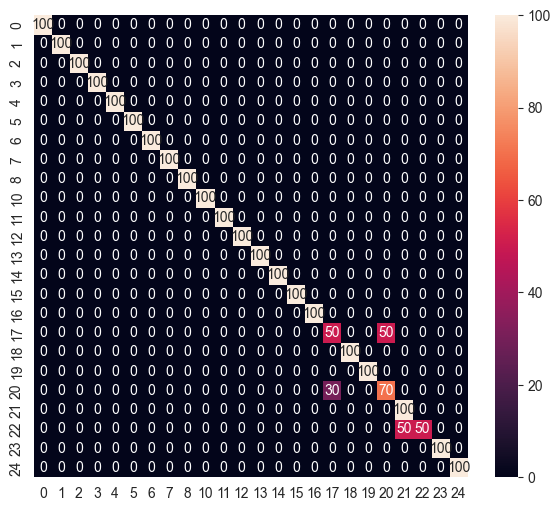

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100
           3       1.00      1.00      1.00       100
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       100
           6       1.00      1.00      1.00       100
           7       1.00      1.00      1.00       100
           8       1.00      1.00      1.00       100
          10       1.00      1.00      1.00       100
          11       1.00      1.00      1.00       100
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00       100
          14       1.00      1.00      1.00       100
          15       1.00      1.00      1.00       100
          16       1.00      1.00      1.00       100
          17       0.62      0.50      0.56       100
     

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_testGood, y_pred))

Y_pred = model.predict(X_testGood)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_testGood, y_pred)

# Convert to model for Tensorflow-Lite

In [21]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpdj6vredb\assets


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmpdj6vredb\assets


513904

# Inference test

In [23]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [24]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [25]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_testGood[0]]))

In [26]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [27]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.0000000e+00 0.0000000e+00 1.6815582e-44 7.2029656e-34 0.0000000e+00
 0.0000000e+00 9.6592480e-26 2.6977270e-21 1.3217301e-31 3.8373157e-41
 2.5493153e-31 5.1290803e-14 2.8025969e-45 1.1352142e-34 8.8715286e-28
 5.6871692e-30 4.4420978e-23 5.3529601e-43 1.2874377e-32 3.2445824e-15
 3.9761788e-38 0.0000000e+00 1.1588738e-42 3.4389885e-20 9.9741776e-22
 1.8397090e-38]
0


In [28]:
# Save the model
model.save(model_save_path, include_optimizer=False)

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Write the TFLite file
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

C:\gesture_recognition_by_image\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmp3sixjqpm\assets


INFO:tensorflow:Assets written to: C:\Users\joren\AppData\Local\Temp\tmp3sixjqpm\assets


#### Loss  (cost)

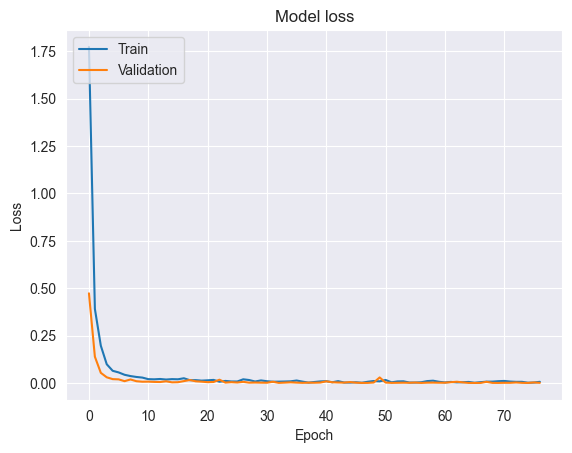

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

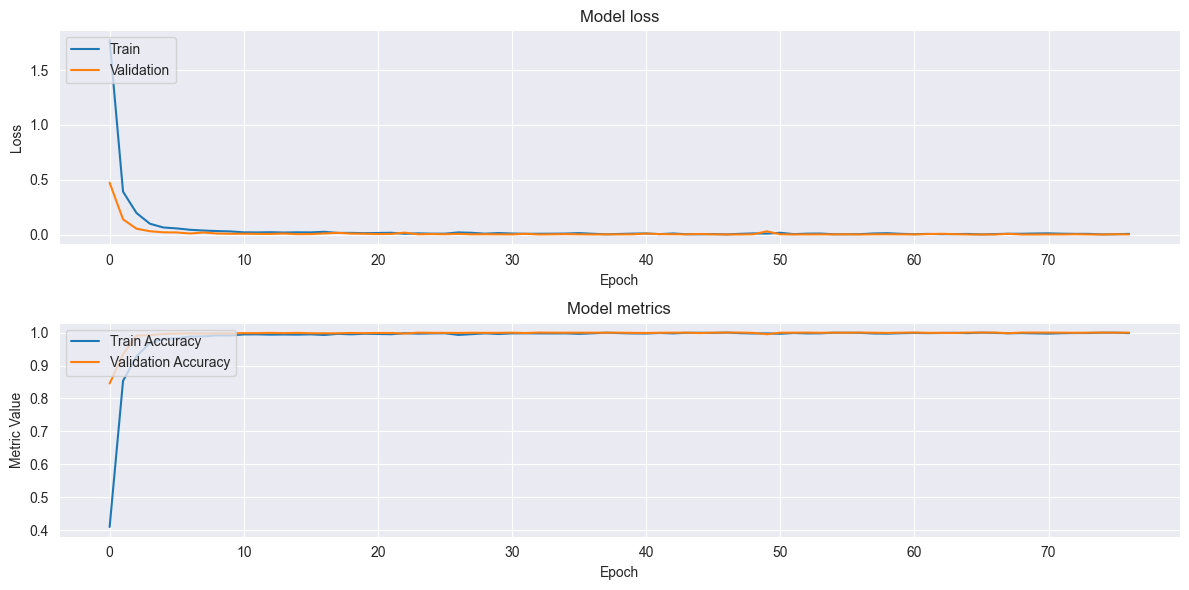

In [30]:
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy and F1 score values
plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'F1 Score'], loc='upper left')

plt.tight_layout()
plt.show()

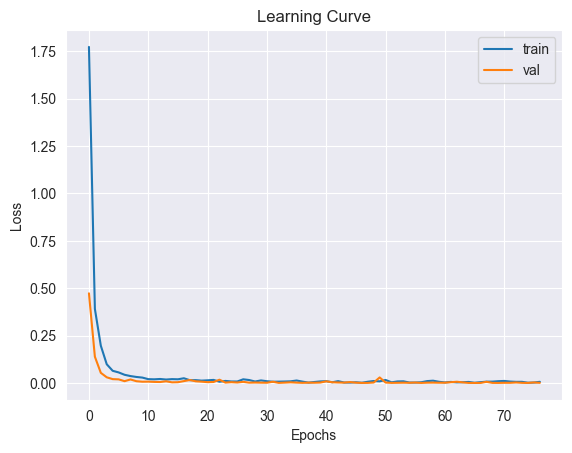

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()